# Implementaton of recommendation system

Author: Mo LI(mo.li@ensae.fr) Zhonghao LI(zhonghao_li@ensae.fr)

The goal of this notebook is to implement two calssic recommendation system models, namely Funk SVD and BSVD. We used a dataset "ratings.csv" which contains the ratings of users to a pool of movies. 

## Our dataset

In [2]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [16]:
dataset = pd.read_csv("ratings.csv", usecols=range(3), dtype=dict(dtype))
pd.DataFrame(dataset)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [27]:
## Transform the dataset to a matrix form with user id and movie id as indexs.
dataset_table = dataset.pivot_table(index=["userId"], columns=["movieId"],values="rating")
dataset_table

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## FunkSVD 

Let's first consider the Funk SVD method. The main idea of this method has been presented in the attached .pdf file.

In [3]:
class LFM(object):

    def __init__(self, alpha, reg_p, reg_q, number_LatentFactors=10, number_epochs=10, columns=["uid", "iid", "rating"]):
        '''
        init of the parameters
        '''
        self.alpha = alpha 
        self.reg_p = reg_p   
        self.reg_q = reg_q   
        self.number_LatentFactors = number_LatentFactors  
        self.number_epochs = number_epochs   
        self.columns = columns

    def fit(self, dataset):
        '''
        fit dataset
        :param dataset: uid, iid, rating
        :return: P,Q and loss
        '''

        self.dataset = pd.DataFrame(dataset)

        self.users_ratings = dataset.groupby(self.columns[0]).agg([list])[[self.columns[1], self.columns[2]]]
        self.items_ratings = dataset.groupby(self.columns[1]).agg([list])[[self.columns[0], self.columns[2]]]

        self.globalMean = self.dataset[self.columns[2]].mean()

        self.P, self.Q, self.loss_list = self.sgd()

    def _init_matrix(self):
        '''
        Initialisation of the two matrixs. 
        Here we used random varibales uniformly distributed in [0,1] as the initialisation of both P and Q
        '''

        # User-LF
        P = dict(zip(
            self.users_ratings.index,
            np.random.rand(len(self.users_ratings), self.number_LatentFactors).astype(np.float32)
        ))
        # Item-LF
        Q = dict(zip(
            self.items_ratings.index,
            np.random.rand(len(self.items_ratings), self.number_LatentFactors).astype(np.float32)
        ))
        return P, Q

    def sgd(self):
        '''
        stochastic gradient descent
        '''
        
        P, Q = self._init_matrix()
        loss_list = []
        
        for i in range(self.number_epochs):
            print("iter%d"%int(i+1))
            error_list = []
            for uid, iid, r_ui in self.dataset.itertuples(index=False):
                # User-LF P
                ## Item-LF Q
                v_pu = P[uid] 
                v_qi = Q[iid] 
                err = np.float32(r_ui - np.dot(v_pu, v_qi))

                v_pu += self.alpha * (err * v_qi - self.reg_p * v_pu)
                v_qi += self.alpha * (err * v_pu - self.reg_q * v_qi)

                P[uid] = v_pu 
                Q[iid] = v_qi

                # for k in range(self.number_of_LatentFactors):
                #     v_pu[k] += self.alpha*(err*v_qi[k] - self.reg_p*v_pu[k])
                #     v_qi[k] += self.alpha*(err*v_pu[k] - self.reg_q*v_qi[k])

                error_list.append(err ** 2)
            loss_list.append(np.sqrt(np.mean(error_list)))  ## MSE is calculated as the error term
            print(np.sqrt(np.mean(error_list)))

        RMSE_train = np.sqrt(np.mean(error_list))
        print("RMSE_train:%f" %RMSE_train)
        
        return P, Q, loss_list

    def predict(self, uid, iid):
        '''
        For the prediction, if we have no infromation 
        '''

        if uid not in self.users_ratings.index or iid not in self.items_ratings.index:
            return self.globalMean

        p_u = self.P[uid]
        q_i = self.Q[iid]

        return np.dot(p_u, q_i)

    def test(self,testset):
        
        error_test_list = []
        for uid, iid, real_rating in testset.itertuples(index=False):
            
            pred_rating = self.predict(uid, iid)
            err_test = np.float32(real_rating-pred_rating)
            error_test_list.append(err_test ** 2)
        
        RMSE_test = np.sqrt(np.mean(error_test_list))
        print("RMSE_test:%f" %RMSE_test)
        self.RMSE_test = RMSE_test
            
        

Among all the parameters, the one we are intersted the most is the number of latent factors, who decides the complexity of our model. It shouldn't be too big, in which case we may encounter over-fitting. In the following, we did a train-test split of our dataset and we try to see which choice of this parameter out-performes.

In [14]:
if __name__ == '__main__':
    dtype = [("userId", np.int32), ("movieId", np.int32), ("rating", np.float32)]
    dataset = pd.read_csv("ratings.csv", usecols=range(3), dtype=dict(dtype))

    data_train, data_test = train_test_split(dataset, test_size=0.1, random_state=0, stratify=dataset['userId'])
    
    RMSE_test_list = []
    RMSE_train_list = []
    for num_latent_factors in range(1,40): 
        print('Latent factors number = %d' %num_latent_factors)
        lfm = LFM(0.02, 0.1, 0.1, num_latent_factors, 10, ["userId", "movieId", "rating"])
        lfm.fit(data_train)
        lfm.test(data_test)
        RMSE_test_list.append(lfm.RMSE_test)
        RMSE_train_list.append(lfm.loss_list[-1])
        
        

D:\Anaconda\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
D:\Anaconda\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addition

Latent factors number = 1
iter1
1.7706713720725136
iter2
1.0668283125998343
iter3
0.9742559955709824
iter4
0.9352074069089457
iter5
0.9127383903433064
iter6
0.8977764072279364
iter7
0.8869607810960062
iter8
0.8787243299737938
iter9
0.8722231151359565
iter10
0.8669566011304797
RMSE_train:0.866957
RMSE_test:0.916649
Latent factors number = 2
iter1
1.5381660360683573
iter2
1.0026454529926976
iter3
0.9375200948369831
iter4
0.9096313847519523
iter5
0.893170383305694
iter6
0.8818690768815494
iter7
0.8734170492864967
iter8
0.8667316169825061
iter9
0.8612235834583949
iter10
0.8565388026005065
RMSE_train:0.856539
RMSE_test:0.912551
Latent factors number = 3
iter1
1.4018391209446806
iter2
0.9658275821133134
iter3
0.9161415697259518
iter4
0.8941055230852046
iter5
0.8806118197903086
iter6
0.8709874959212027
iter7
0.8634616658221678
iter8
0.8571748183729455
iter9
0.8516424223645241
iter10
0.8465684507273731
RMSE_train:0.846568
RMSE_test:0.908004
Latent factors number = 4
iter1
1.2919272087636657
it

iter1
1.1507572741497352
iter2
0.9141080082556866
iter3
0.8764858905909088
iter4
0.8539357478644696
iter5
0.8366702837798926
iter6
0.8216714608240286
iter7
0.8077062782528132
iter8
0.7942547942716155
iter9
0.7811557016377201
iter10
0.7684305867960344
RMSE_train:0.768431
RMSE_test:0.908966
Latent factors number = 28
iter1
1.163897851605543
iter2
0.9159802644282047
iter3
0.877447737046036
iter4
0.8540531127735767
iter5
0.8359411511028683
iter6
0.8201065705789156
iter7
0.8053748979309127
iter8
0.7912855248774522
iter9
0.7777050009626209
iter10
0.7646437028772681
RMSE_train:0.764644
RMSE_test:0.914457
Latent factors number = 29
iter1
1.182721957463365
iter2
0.9190789757232708
iter3
0.8795760345042177
iter4
0.8561712938500827
iter5
0.8383234905650955
iter6
0.8228165087304017
iter7
0.8083406509097751
iter8
0.7943322297973979
iter9
0.7806009599964622
iter10
0.7671612563378067
RMSE_train:0.767161
RMSE_test:0.916306
Latent factors number = 30
iter1
1.1982633675297927
iter2
0.9200284610477876
it

Unsurprisingly, the loss in the training set decreases monotonly when the number of latent factor grows larger and larger. But we can see that in the test set, the RMSE drops at first and then grows rapidly as we put larger number of latent factors. Thus, we recommmand to choose a relatively small number of latent factors in order to get a good performence in the test set.

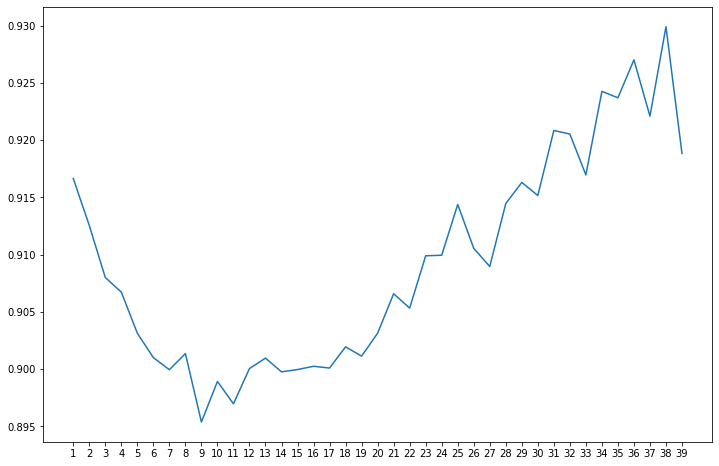

In [23]:
plt.subplots(figsize=(12, 8))
plt.xticks(range(1,40))
plt.plot(range(1,40), RMSE_test_list)
plt.show()

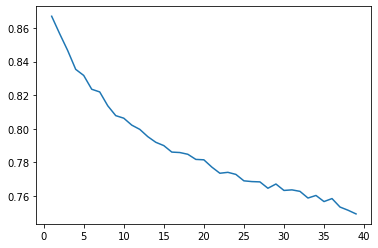

In [38]:
plt.plot(range(1,40), RMSE_train_list)
plt.show()

In the following, we set the number of latent factors to be 9. We are intersted in wheter this method has done a good job in the prediction.

In [21]:
lfm_9 = LFM(0.02, 0.1, 0.1, 9, 100, ["userId", "movieId", "rating"])
lfm_9.fit(data_train)

iter1
1.0428511529908826
iter2
0.898608505210957
iter3
0.8719462070120291
iter4
0.8571619067097104
iter5
0.8466893852357712
iter6
0.8381608367593184
iter7
0.8305113687357695
iter8
0.823169237774908
iter9
0.8158177684398648
iter10
0.8083151089460916
iter11
0.8006544905731622
iter12
0.7929212412909189
iter13
0.7852408037266626
iter14
0.77773366171364
iter15
0.77049109460841
iter16
0.7635708531810022
iter17
0.757003099887498
iter18
0.7507984597480621
iter19
0.7449547278983208
iter20
0.7394616694866951
iter21
0.7343042739772963
iter22
0.7294649599245476
iter23
0.7249249960098724
iter24
0.7206653992449421
iter25
0.7166675016314253
iter26
0.712913257154194
iter27
0.7093854713896184
iter28
0.706067876965752
iter29
0.7029452133395109
iter30
0.7000032330588452
iter31
0.6972286929374837
iter32
0.6946093251905464
iter33
0.692133796303653
iter34
0.6897916562558728
iter35
0.6875732782027787
iter36
0.6854698146390794
iter37
0.6834731267556224
iter38
0.6815757489232038
iter39
0.6797708101629886
iter4

In [42]:
lfm_9.test(data_test)

RMSE_test:0.890424


First, we trained the model and verified that the error is decreasing after each iteration.

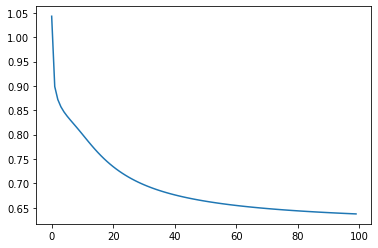

In [24]:
plt.plot(range(100), lfm_9.loss_list)
plt.show()

To get the prediction matrix, we simply obtained the two matrix P and Q updated in the model and calculated PQ'.

In [25]:
P_matrix = pd.DataFrame(lfm_9.P).T
Q_matrix = pd.DataFrame(lfm_9.Q).T
predict_matrix = P_matrix.dot(Q_matrix.T)
pd.DataFrame(predict_matrix)

,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193567,193571,193573,193579,193583,193585,193587,193609
1,4.570023,4.155193,3.937938,2.766731,3.379559,4.587945,3.516638,2.831485,3.418329,4.153458,...,4.760129,3.971573,3.345803,4.752813,4.487018,3.906938,3.784321,4.262134,4.310342,4.684380
2,4.032980,3.548849,3.589833,2.144287,3.108692,3.553666,3.417196,3.893579,3.091995,3.826603,...,3.656459,3.188209,3.165994,4.247219,2.876609,3.465901,2.712333,3.981998,3.595843,3.774336
3,1.468560,1.639368,1.778849,-0.481573,1.456383,1.783360,0.421272,2.107284,1.232016,1.408406,...,2.309201,1.186163,0.904441,2.128647,0.874426,0.693624,1.486501,1.259747,2.342587,2.006674
4,2.953129,2.411898,2.276068,2.824500,1.846942,3.230889,2.480309,1.971342,2.619953,3.373726,...,2.914018,3.179875,2.812576,3.316631,3.422992,3.384594,2.144211,3.405114,2.654032,3.228305
5,3.489345,2.959713,2.921093,1.652770,2.315076,3.292917,2.597517,1.736456,2.177453,2.560658,...,3.315952,2.689300,2.378341,3.302361,3.298865,2.796736,3.108227,2.729639,2.892604,3.263465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.816316,3.205412,3.074627,2.416036,2.616763,3.873869,3.138024,2.331018,2.596301,3.557582,...,3.745866,3.401222,3.004670,3.779366,3.815733,3.512001,3.065206,3.620976,3.361293,3.896756
607,3.773550,3.755844,3.966691,2.777011,2.630641,3.723166,3.034539,2.806473,3.313601,3.542031,...,3.920537,3.272670,2.525300,4.203661,4.073487,3.335517,3.162503,4.252737,3.711696,4.197125
608,2.685666,2.604435,2.579715,2.233618,1.957603,3.614974,2.082666,1.986838,2.387810,3.579620,...,3.741475,3.350871,2.229775,3.198588,3.753327,2.900868,2.678293,3.722813,3.092000,3.533860
609,3.350683,3.061484,2.985881,2.173813,2.590062,3.266742,2.520480,2.642200,2.855172,3.237835,...,3.482527,3.062326,2.550925,3.762326,3.167195,2.969988,2.653066,3.335910,3.248773,3.521871


We took the first 10 users and the first 15 movies for example to see how well this method did.

In [33]:
# The original training dataset

train_dataset_table = data_train.pivot_table(index=["userId"], columns=["movieId"],values="rating")

train_dataset_matrix = np.matrix(train_dataset_table)
train_dataset_sample = train_dataset_matrix[0:10,0:20]
pd.DataFrame(train_dataset_sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,4.0,5.0,3.0,5.0,4.0,4.0,NaN,NaN,3.0,4.0,NaN,NaN,NaN,4.0,4.0,4.0,NaN,NaN,NaN
6,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# prediction generated by our method
predict_matrix = np.matrix(predict_matrix)
predict_sample = predict_matrix[0:10,0:20]
pd.DataFrame(predict_sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,4.570023,4.155193,3.937938,2.766731,3.379559,4.587945,3.516638,2.831485,3.418329,4.153458,4.315462,2.933523,3.591005,4.279943,3.759598,4.802400,4.832886,4.457937,2.927960,3.298400
1,4.032980,3.548849,3.589833,2.144287,3.108692,3.553666,3.417196,3.893579,3.091995,3.826603,3.217915,2.541419,2.824750,3.192009,2.710941,3.479499,3.090073,4.019158,3.493241,2.312548
2,1.468560,1.639368,1.778849,-0.481573,1.456383,1.783360,0.421272,2.107284,1.232016,1.408406,1.294293,0.852421,0.316359,-0.120246,0.519594,1.396172,0.454630,2.282295,2.770042,-0.391405
3,2.953129,2.411898,2.276068,2.824500,1.846942,3.230889,2.480309,1.971342,2.619953,3.373726,2.009838,2.973283,2.493029,3.221330,2.929371,3.698289,3.667637,2.469572,2.380383,2.832324
4,3.489345,2.959713,2.921093,1.652770,2.315076,3.292917,2.597517,1.736456,2.177453,2.560658,3.091337,1.455885,2.600305,3.332551,2.631450,3.372939,3.442425,3.226442,1.839248,2.669246
5,4.349549,3.919469,3.427330,2.810839,3.709513,3.694426,3.879231,3.306292,3.369478,4.150284,4.053948,2.443549,3.726924,3.999247,3.554008,3.882609,3.759711,3.956103,2.489550,2.579350
6,3.602085,2.842058,3.021790,1.548408,2.097393,3.736522,3.167666,2.509198,1.951330,3.391388,2.874011,2.658488,2.998583,3.571625,1.868116,3.528315,2.006760,3.549342,2.244847,3.038247
7,3.531749,3.221044,3.381253,2.070965,2.417345,3.474749,2.458058,2.351344,2.838466,2.958863,3.208164,2.492975,2.475839,3.200447,2.954689,3.656900,3.364034,3.530929,2.579680,2.754382
8,3.647114,2.987789,3.024636,1.466129,2.580485,3.818404,2.359810,2.528416,2.522759,3.214076,2.613300,2.335690,2.450024,3.174816,2.455207,4.027970,2.679066,3.763861,3.101181,2.352960
9,2.468684,2.784361,2.574452,2.836245,1.805128,2.994562,2.447353,1.989172,2.724797,3.526011,3.218493,3.704787,2.703434,2.432487,2.855956,2.985711,2.946373,2.381852,1.717250,2.389466


We drew the fiures to present the ratings of the the users. Each row represent a user and each column represents a movie. The darker the block it is, the higher the rating (or prediction) it is. We can see that this method did a good restorization on the given data and predicted some of the other blocks to be highly recommended which was a missing data in the original dataset.

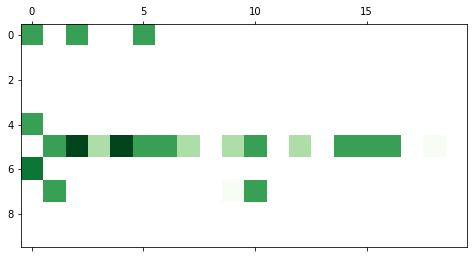

In [36]:
plt.matshow(dataset_sample, cmap=plt.get_cmap('Greens'))

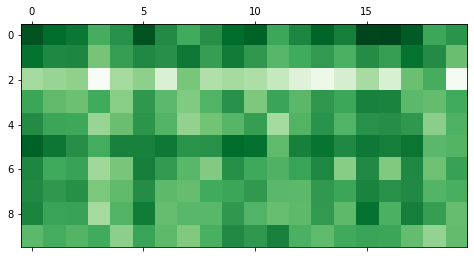

In [37]:
plt.matshow(predict_sample, cmap=plt.get_cmap('Greens'))

In [6]:
rating_matrix_train = data_train.pivot_table(index=["userId"], columns=["movieId"],values="rating")

In [7]:
rating_matrix_train

movieId,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193567,193571,193573,193579,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
rating_matrix = dataset.pivot_table(index=["userId"], columns=["movieId"],values="rating")

In [30]:
rating_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## BSVD

We did the same thing for the BSVD method.

In [40]:
class BiasSvd(object):

    def __init__(self, alpha, reg_p, reg_q, reg_bu, reg_bi, number_LatentFactors=10, number_epochs=10, columns=["uid", "iid", "rating"]):
        self.alpha = alpha 
        self.reg_p = reg_p
        self.reg_q = reg_q
        self.reg_bu = reg_bu
        self.reg_bi = reg_bi
        self.number_LatentFactors = number_LatentFactors  
        self.number_epochs = number_epochs
        self.columns = columns

    def fit(self, dataset):
        '''
        fit dataset
        :param dataset: uid, iid, rating
        :return:
        '''

        self.dataset = pd.DataFrame(dataset)

        self.users_ratings = dataset.groupby(self.columns[0]).agg([list])[[self.columns[1], self.columns[2]]]
        self.items_ratings = dataset.groupby(self.columns[1]).agg([list])[[self.columns[0], self.columns[2]]]
        self.globalMean = self.dataset[self.columns[2]].mean()

        self.P, self.Q, self.bu, self.bi, self.loss_list = self.sgd()

    def _init_matrix(self):

        # User-LF
        P = dict(zip(
            self.users_ratings.index,
            np.random.rand(len(self.users_ratings), self.number_LatentFactors).astype(np.float32)
        ))
        # Item-LF
        Q = dict(zip(
            self.items_ratings.index,
            np.random.rand(len(self.items_ratings), self.number_LatentFactors).astype(np.float32)
        ))
        return P, Q

    def sgd(self):

        P, Q = self._init_matrix()
        loss_list = []

        bu = dict(zip(self.users_ratings.index, np.zeros(len(self.users_ratings))))
        bi = dict(zip(self.items_ratings.index, np.zeros(len(self.items_ratings))))

        for i in range(self.number_epochs):
            print("iter%d"%i)
            error_list = []
            for uid, iid, r_ui in self.dataset.itertuples(index=False):
                v_pu = P[uid]
                v_qi = Q[iid]
                err = np.float32(r_ui - self.globalMean - bu[uid] - bi[iid] - np.dot(v_pu, v_qi))

                v_pu += self.alpha * (err * v_qi - self.reg_p * v_pu)
                v_qi += self.alpha * (err * v_pu - self.reg_q * v_qi)

                P[uid] = v_pu 
                Q[iid] = v_qi

                bu[uid] += self.alpha * (err - self.reg_bu * bu[uid])
                bi[iid] += self.alpha * (err - self.reg_bi * bi[iid])

                error_list.append(err ** 2)
            loss_list.append(np.sqrt(np.mean(error_list)))
            print(np.sqrt(np.mean(error_list)))

        RMSE_train = np.sqrt(np.mean(error_list))
        print("RMSE_train:%f" %RMSE_train)

        return P, Q, bu, bi, loss_list

    def predict(self, uid, iid):

        if uid not in self.users_ratings.index or iid not in self.items_ratings.index:
            return self.globalMean

        p_u = self.P[uid]
        q_i = self.Q[iid]

        return self.globalMean + self.bu[uid] + self.bi[iid] + np.dot(p_u, q_i)
    
    def test(self,testset):
        
        error_test_list = []
        for uid, iid, real_rating in testset.itertuples(index=False):
            
            pred_rating = self.predict(uid, iid)
            err_test = np.float32(real_rating-pred_rating)
            error_test_list.append(err_test ** 2)
        
        RMSE_test = np.sqrt(np.mean(error_test_list))
        print("RMSE_test:%f" %RMSE_test)
        self.RMSE_test = RMSE_test



In [44]:
if __name__ == '__main__':
    dtype = [("userId", np.int32), ("movieId", np.int32), ("rating", np.float32)]
    dataset = pd.read_csv("ratings.csv", usecols=range(3), dtype=dict(dtype))

    data_train, data_test = train_test_split(dataset, test_size=0.1, random_state=0, stratify=dataset['userId'])
    
    RMSE_test_list = []
    RMSE_train_list = []
    for num_latent_factors in range(1,20): 
        print('Latent factors number = %d' %num_latent_factors)
        bsvd = BiasSvd(0.02, 0.2, 0.2, 0.2, 0.2, num_latent_factors, 10, ["userId", "movieId", "rating"])
        bsvd.fit(data_train)
        bsvd.test(data_test)
        RMSE_test_list.append(bsvd.RMSE_test)
        RMSE_train_list.append(bsvd.loss_list[-1])


D:\Anaconda\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
D:\Anaconda\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addition

Latent factors number = 1
iter0
0.9285386161057455
iter1
0.8798462306415938
iter2
0.8634149464127873
iter3
0.8532017365971117
iter4
0.8458545129460555
iter5
0.8401566218863264
iter6
0.8355262400192529
iter7
0.8316391960891933
iter8
0.8282961562441086
iter9
0.8253658958398431
RMSE_train:0.825366
RMSE_test:0.874991
Latent factors number = 2
iter0
0.9373376275102853
iter1
0.8798482402953284
iter2
0.8620573493333317
iter3
0.8510378304164089
iter4
0.8431201613452808
iter5
0.8369973541761117
iter6
0.8320445429428185
iter7
0.8279109621297195
iter8
0.8243786584661694
iter9
0.8213025540714023
RMSE_train:0.821303
RMSE_test:0.873688
Latent factors number = 3
iter0
0.94714920985447
iter1
0.8799590342674707
iter2
0.8610050072197883
iter3
0.8494193696043306
iter4
0.8411434598956977
iter5
0.8347736446633214
iter6
0.8296448764322039
iter7
0.8253843746258452
iter8
0.8217607085027033
iter9
0.8186204292239058
RMSE_train:0.818620
RMSE_test:0.873726
Latent factors number = 4
iter0
0.9620524324051319
iter1


As what we have seen in the Funk SVD, this method has also a problem of over-fitting. We still recommende to choose the number of latent factor relatively small to get a better performance in the test dataset.

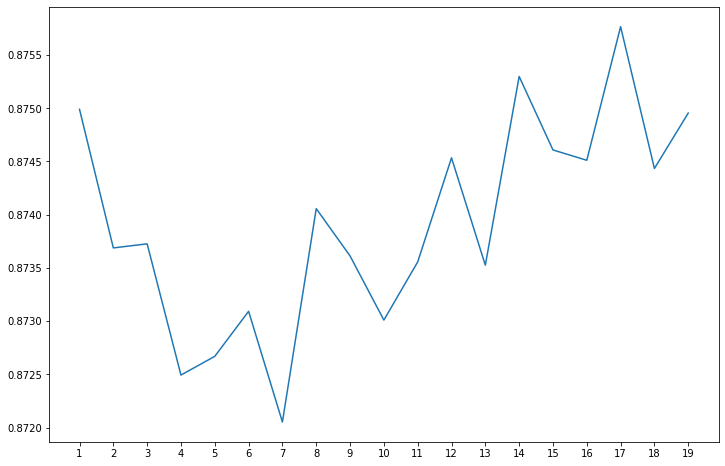

In [47]:
plt.subplots(figsize=(12, 8))
plt.xticks(range(1,20))
plt.plot(range(1,20), RMSE_test_list)
plt.show()

However, we can see that this BSVD method has a lower error in the test dataset than the previous Funk SVD method. This means that this method is probably more suitable for this dataset as a recommendation system.

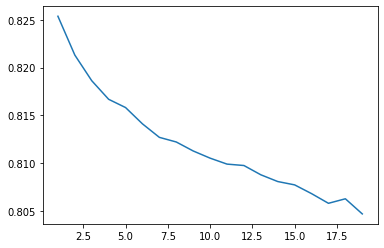

In [48]:
plt.plot(range(1,20), RMSE_train_list)

In [50]:
bsvd_7 = BiasSvd(0.02, 0.2, 0.2, 0.2, 0.2, 7, 100, ["userId", "movieId", "rating"])
bsvd_7.fit(data_train)
bsvd_7.test(data_test)

iter0
1.0125590747969877
iter1
0.8822210522763535
iter2
0.8595045104012418
iter3
0.8464305617171137
iter4
0.8372913074891271
iter5
0.8303459937891048
iter6
0.8248110354887525
iter7
0.8202554861091856
iter8
0.8164130087676519
iter9
0.8131066958954868
iter10
0.8102133145304774
iter11
0.8076439990936147
iter12
0.8053328723862998
iter13
0.8032299601985158
iter14
0.8012966338387318
iter15
0.7995025852523924
iter16
0.797823766918224
iter17
0.7962409267135746
iter18
0.7947385341157461
iter19
0.7933039741790637
iter20
0.7919269301667254
iter21
0.7905989132516291
iter22
0.7893129082214255
iter23
0.7880631084581682
iter24
0.7868447219469544
iter25
0.7856538295872754
iter26
0.7844872794794138
iter27
0.783342601918162
iter28
0.7822179401447144
iter29
0.781111983551154
iter30
0.7800239026468319
iter31
0.7789532805378235
iter32
0.7779000439953678
iter33
0.7768643887297686
iter34
0.775846714058402
iter35
0.7748475485144097
iter36
0.7738674923659514
iter37
0.7729071588101679
iter38
0.7719671345257975


In [93]:
P = pd.DataFrame(bsvd_7.P).T
Q = pd.DataFrame(bsvd_7.Q).T
bi = pd.DataFrame([bsvd_7.bi])
bu = pd.DataFrame([bsvd_7.bu]).T

In [102]:
bsvd7_predict_matrix = pd.DataFrame(np.matrix(P.dot(Q.T)) + np.matrix(bu.T) + np.matrix(bi) + bsvd_7.globalMean)

In [103]:
bsvd7_predict_matrix

,0,1,2,3,4,5,6,7,8,9,...,9351,9352,9353,9354,9355,9356,9357,9358,9359,9360
0,4.504596,4.167354,3.991212,3.354838,3.752061,4.514393,3.905719,3.604497,3.775122,4.211702,...,4.897698,4.432896,3.968807,4.643773,4.482297,4.388420,4.306603,4.355755,4.317659,4.734340
1,3.891235,3.636671,3.390923,2.788633,3.218608,3.869934,3.321447,3.425910,3.285568,3.745785,...,4.626235,4.297239,3.781156,4.424292,4.146549,3.949343,4.227018,4.057419,3.983902,4.520868
2,2.202108,2.194954,2.251022,1.189178,1.760920,2.439774,1.843876,3.218250,2.135224,2.682187,...,4.037265,3.793017,3.108023,4.064835,3.203058,3.075548,4.332723,3.432805,3.357449,3.452176
3,3.787940,3.268156,2.949657,2.516565,2.819371,3.634419,3.054771,2.685677,3.050196,3.392321,...,4.462457,3.921288,3.286740,3.678278,3.843552,3.862361,3.613299,3.836910,3.986764,4.502440
4,3.684030,3.330292,3.190430,2.524695,2.897641,3.739954,3.071085,2.726050,2.923811,3.384724,...,4.117377,3.533354,3.087926,3.822622,3.630271,3.596048,3.462364,3.565098,3.517935,3.908994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,3.809183,3.456906,3.278594,2.642489,3.034443,3.848811,3.204927,2.934967,3.072666,3.531466,...,4.305819,3.788690,3.363577,4.056383,3.817835,3.701039,3.693213,3.700635,3.729885,4.158040
606,3.898118,3.666856,3.494397,2.818740,3.264706,3.910311,3.370371,3.469818,3.350330,3.797355,...,4.498181,4.221315,3.655900,4.401903,4.124029,3.983133,4.194396,3.980390,3.974113,4.289753
607,3.497329,3.194554,3.077044,2.307209,2.808814,3.612713,2.937118,2.759374,2.704785,3.339194,...,3.816887,3.368765,2.912740,3.636114,3.476341,3.267336,3.311998,3.241426,3.267358,3.463226
608,3.536779,3.211544,3.058501,2.389210,2.792205,3.572390,2.959408,2.821753,2.891606,3.316940,...,4.121873,3.665786,3.189330,3.896382,3.631398,3.539354,3.608172,3.537450,3.573017,3.941677


In [104]:
# The original training dataset

train_dataset_table = data_train.pivot_table(index=["userId"], columns=["movieId"],values="rating")

train_dataset_matrix = np.matrix(train_dataset_table)
train_dataset_sample = train_dataset_matrix[0:10,0:20]
#pd.DataFrame(train_dataset_sample)
pd.DataFrame(train_dataset_matrix)

,0,1,2,3,4,5,6,7,8,9,...,9351,9352,9353,9354,9355,9356,9357,9358,9359,9360
0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
# prediction generated by our method
predict_matrix = np.matrix(bsvd7_predict_matrix)
predict_sample = predict_matrix[0:10,0:20]
pd.DataFrame(predict_sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,4.504596,4.167354,3.991212,3.354838,3.752061,4.514393,3.905719,3.604497,3.775122,4.211702,4.307251,3.371069,4.024863,4.331549,3.690766,4.573797,4.427357,4.494238,3.510151,3.477056
1,3.891235,3.636671,3.390923,2.788633,3.218608,3.869934,3.321447,3.425910,3.285568,3.745785,3.750471,3.081818,3.507944,3.610286,3.220933,3.904057,3.866083,3.890618,2.887665,2.840268
2,2.202108,2.194954,2.251022,1.189178,1.760920,2.439774,1.843876,3.218250,2.135224,2.682187,2.194663,2.581435,1.962272,1.948248,2.062412,2.734981,2.321203,2.481205,1.782305,1.587956
3,3.787940,3.268156,2.949657,2.516565,2.819371,3.634419,3.054771,2.685677,3.050196,3.392321,3.533621,2.535427,3.377703,3.290358,3.034043,3.639195,3.442325,3.539085,2.795733,2.632809
4,3.684030,3.330292,3.190430,2.524695,2.897641,3.739954,3.071085,2.726050,2.923811,3.384724,3.456387,2.491294,3.174149,3.583992,2.898454,3.827027,3.659063,3.676587,2.734853,2.744725
5,3.967339,3.688627,3.485715,2.835175,3.284203,3.975255,3.384554,3.284001,3.246242,3.787742,3.885363,3.025077,3.520218,3.706307,3.232022,4.027877,3.765476,3.930787,2.955094,2.924458
6,3.648027,3.235624,2.961619,2.426515,2.790706,3.634329,2.920947,2.278417,2.580767,3.192362,3.433274,2.141854,3.081892,3.560538,2.761686,3.643881,3.507816,3.482774,2.547107,2.587627
7,3.820026,3.419874,3.239608,2.599430,3.008952,3.837339,3.188473,2.759674,2.994918,3.473316,3.563038,2.597818,3.291871,3.688555,2.964516,3.879991,3.693954,3.763949,2.867390,2.769639
8,3.789670,3.281332,3.204175,2.465463,2.885838,3.863524,3.120605,2.287825,2.790182,3.338777,3.526692,2.301407,3.137170,3.725256,2.810984,3.952833,3.406649,3.673763,2.923452,2.771103
9,3.335035,3.217638,3.085913,2.454341,2.786143,3.305189,2.894630,3.335670,3.198738,3.371231,3.376912,2.785784,3.118330,2.811602,2.823172,3.453685,3.351524,3.494351,2.278706,2.436144


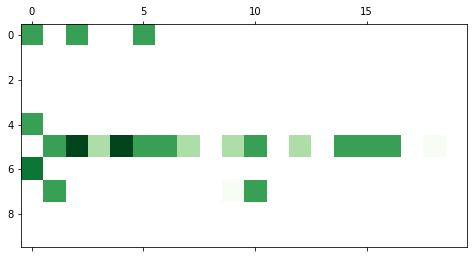

In [109]:
plt.matshow(dataset_sample, cmap=plt.get_cmap('Greens'))
plt.show()

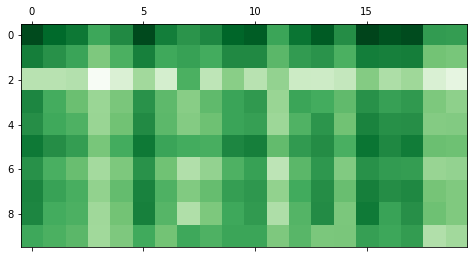

In [108]:
plt.matshow(predict_sample, cmap=plt.get_cmap('Greens'))
plt.show()